# Coordinate Systems

## Overview 
**This tutorial covers:**

- The relationship of different coordinate systems towards each other and how they are handled by WelDX

**Requirements:**

Opening and navigating through WelDX files
 TODO: link tutorial, once it is merged

## Dependency graph

All spatial data like specimen geometries, or the trajectory of a welding torch is defined in a coordinate system that serves as anchor point.
But this isn't necessarily always the same coordinate system.
In fact, it is often more convenient to use different coordinate systems for individual data sets.
This raises the problem that we need to know how the different systems are oriented towards each other.
WelDX ensures this by a special tree like structure called the `CoordinateSystemManager` (we will use the abbreviation CSM from here on) that need to be part of almost every WelDX file.
Let's find it in our example file and extract it to see what we can do with it:

In [1]:
from weldx import WeldxFile
wxfile = WeldxFile("single_pass_weld.wx")

c:\users\vhirtham\pycharmprojects\bam\libo\libo\__init__.py:29: UserWarning: Using local libo package files without version information.
Consider running 'python setup.py --version' or 'pip install -e .' in the libo root repository
  warnings.warn(
c:\users\vhirtham\pycharmprojects\bam\libo\libo\__init__.py:29: UserWarning: Using local libo package files without version information.
Consider running 'python setup.py --version' or 'pip install -e .' in the libo root repository
  warnings.warn(


In [2]:
wxfile.info()

root (dict)
├─TCP (LocalCoordinateSystem)
├─coordinate_systems (CoordinateSystemManager)
├─equipment (list)
│ ├─[0] (MeasurementEquipment)
│ ├─[1] (MeasurementEquipment)
│ └─[2] (MeasurementEquipment)
├─measurements (list)
│ ├─[0] (Measurement)
│ ├─[1] (Measurement)
│ ├─[2] (Measurement)
│ └─[3] (Measurement)
├─process (dict)
│ ├─shielding_gas (ShieldingGasForProcedure)
│ ├─weld_speed (TimeSeries)
│ ├─welding_process (GmawProcess)
│ └─welding_wire (dict)
│   ├─class (str)
│   ├─diameter (Q_)
│   └─wx_user (dict)
│     ├─charge id (str)
│     └─manufacturer (str)
├─reference_timestamp (Timestamp)
├─welding_current (TimeSeries)
├─welding_voltage (TimeSeries)
├─workpiece (dict)
│ ├─base_metal (dict)
│ │ ├─common_name (str)
│ │ └─standard (str)
│ └─geometry (dict)
│   ├─groove_shape (VGroove)
│   └─seam_length (Q_)
└─wx_user (dict)
  ├─WID (int)
  ├─operator (str)
  └─project (str)


Examining the `info` output, we find that the object we are looking for is stored under the key `"coordinate_systems"`.

In [3]:
csm = wxfile["coordinate_systems"]

As previously mentioned, the CSM is based on a tree structure.
Every element added to it needs to define the transformation between itself and its parent node.
This ensures in combination with the tree structure that there is always a transformation path between all contained coordinate systems.
We can get a nice overview of all coordinate systems and their relationship towards each other by calling the `plot_graph` method:

<AxesSubplot:>

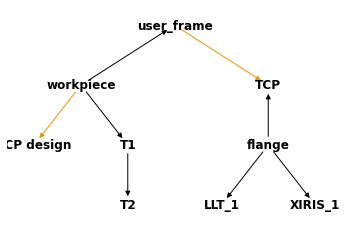

In [4]:
csm.plot_graph()

> HINT: In a jupyter session it is sufficient to just type the variable name at the end of a cell (here `csm`). 
  This will also plot the graph

The plot shows us multiple things.
The most important information are the coordinate system names.
Arrows indicate that there is a transformation defined between two coordinate systems.
The direction of the arrows has no practical relevance for using the CSM.
It just specifies the transformation direction that was originally provided by the creator of the file.
Because we can always calculate the inverse transformation, it can be considered as pure information.
More important is the color of the arrows.
Black arrows indicate that the transformation remains constant during the experiment. 
For example, the coordinate system of a thermal sensor (`T1`) that is attached to a fixed position on the specimen will not change its relative position towards the specimen coordinate system (`workpiece`).
Therefore, the transformation remains constant.
Yellow arrows represent time dependent transformations.
A good for example for this is the torch in a welding application (`TCP`).
During an experiment, it moves in relation to the workpiece.

## Default 3d plot and time interpolation

The graph plot is nice to get a quick overview of the defined coordinate systems and how they depend on each other.
But it doesn't provide us any information on how they are arranged in 3d space.
For this purpose, the CSM also has a `plot` method.
Before we use this method we have to take a small detour and talk about how time dependencies are treated by the CSM.

The number of data points for the torch trajectory (TCP) is relatively high because we are dealing with real measurement data here that was recorded with a high frequency.
If we use the default rendering backend (matplotlib), each time dependent data point is rendered individually.
With huge amount of data, this takes a rather long time to compute and will possibly clutter the image with data points so that is hard to recognize anything.
The solution to both problems is to resample the time dependent data of the CSM.

We do this in three steps.
First we get the `time_union` of the CSM:

In [5]:
time_union = csm.time_union()

The `time_union` method collects every time value of all the time dependent coordinate systems of the CSM and merges them into a `Time` object.
`Time` is a simple class that handles all time related operations.
One of its methods is called `resample`.
With this method we can create a new `Time` object with a specified number of data points that still has the same time boundaries as the original one.
So let's say we want to plot our time dependent data with 10 time steps.
We create a corresponding `Time` object with:

In [6]:
time_resampled = time_union.resample(10)

We pass the resampled time object to the `interp_time` method of the CSM.
This will create a new CSM instance where all time dependent data is interpolated to the passed time values:

In [7]:
csm_interp = csm.interp_time(time_resampled)

Now we can call `plot` of the interpolated CSM without having to worry, that the calculation takes several minutes to create the plot.
Note that we use `data_sets=[]` as additional argument.
This suppresses the rendering of the attached specimen geometry that would clutter the plot.

In [8]:
# uncomment next line to enable interactive plots
# %matplotlib widget

<Axes3DSubplot:xlabel='x', ylabel='y'>

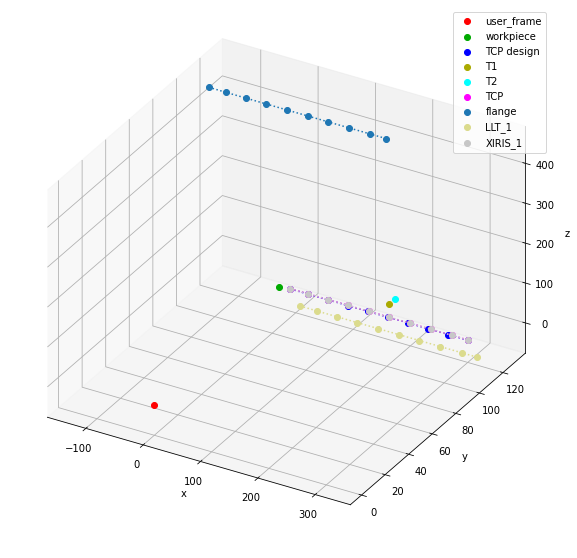

In [9]:
csm_interp.plot(data_sets=[])

The plot shows us the locations of all coordinate systems in 3d space.
Time dependent coordinate systems are represented by multiple control points that are connected by an equally colored line.
Each control point marks the position at one of the time steps we used to interpolate the original CSM.

Depending on the number of coordinate systems, it might be beneficial to render just the ones we are interested in.
For this purpose, we can use the `coordinate_systems` parameter.
It expects a `list` with the names of the coordinate systems we like to render: 

<Axes3DSubplot:xlabel='x', ylabel='y'>

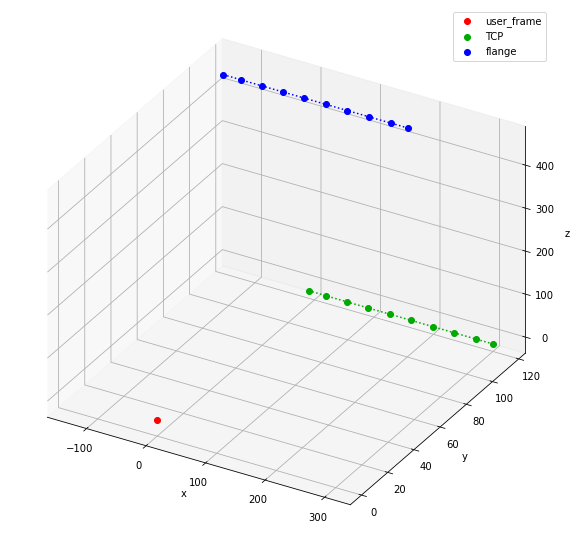

In [10]:
csm_interp.plot(
    coordinate_systems=["user_frame", "TCP", "flange"],
    data_sets=[]
)

By checking the coordinate $x=0$, $y=0$, $z=0$ in the plot, you can derive that all data is plotted in the "user_frame" coordinate system.
This is because it is the root coordinate system of the CSM as can be seen in the graph we plotted earlier.
If you want to change the reference coordinate system, you can do this with the parameter `reference_system`.
This is especially interesting if time dependencies are involved.
Let's see how everything looks how everything looks from the torch's perspective:

<Axes3DSubplot:xlabel='x', ylabel='y'>

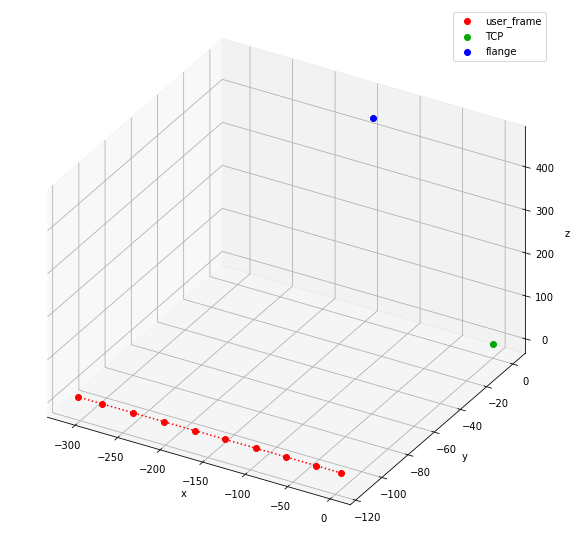

In [11]:
csm_interp.plot(
    coordinate_systems=["user_frame", "TCP", "flange"],
    data_sets=[],
    reference_system="TCP"
)

Now the "user_frame" has suddenly become time dependent, and the flange remains static.
This does make sense considering that the torch is mounted on the flange and both move in relation to the "user_frame" coordinate system.
The `plot` method has a lot more parameters to tweak the plot to your liking.
However, demonstrating them all would exceed the scope of this tutorial.
Checkout the [corresponding API documentation page](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.CoordinateSystemManager.plot.html#weldx.CoordinateSystemManager.plot) to learn about the other options.

## Interactive 3d plots with k3d

As in the previous tutorial about 3d geometries, the CSM also supports `k3d` as rendering backend inside a jupyter notebook session.

> todo: insert link

This rendering backend is much more powerful and doesn't require us to make any compromises by interpolating the data.
It can handle huge datasets quite well.
So we can safely use the original CSM that we stored in the variable `csm`.

The CSM's `plot`method offers a high level of interactivity when using `k3d` as renderer.
This reduces the amount of parameters you need to remember or look up if you want to modify the graphical output to your liking.

If you are not reading this tutorial inside a jupyter notebook, you should start one now.
Otherwise, you won't be able to see the plots.
If you don't want start a jupyter notebook session, you can skip the rest of this section about `k3d` plots.

> HINT: Remember that the online documentation provides a binder-link at the beginning of each tutorial. 
        This starts an online jupyter-lab session that does not require any installations.


Now, if you are ready, uncomment the next line and run it:

In [12]:
# csm.plot(backend="k3d")

The first, most obvious thing you will notice is that the 3d scan of the geometry is now visualized because we didn't disable it anymore.
The representation of the coordinate systems is similar to the one used in the matplotlib plots.
However, the individual data points of time dependent coordinate systems are not rendered anymore.
Instead, the "Time" slider of the control panel below the plot lets you pick a specific point in time.
All coordinate systems are placed at their position accordingly.

The control panel lets you modify the data representation to your liking.
It covers most of the options that can be passed as parameters to the `plot` function.
Try them out, to get a feeling what you can do.

Of course, you can also use the parameters of the `plot` method to disable certain data and to set the initial values of the control panel:

In [13]:
# uncomment next the following lines to run the plot
#csm.plot(
#    coordinate_systems=["user_frame", "TCP", "flange"],
#    data_sets=[],
#    reference_system="TCP",
#    backend="k3d"
#)

## Conclusion

In this tutorial we have learned about the `CoordinateSystemManager` class.
We have gotten a basic overview over the contained coordinate systems and how they depend on each other by plotting the dependency graph using `plot_graph`.
Furthermore, we saw how to use the `plot` method and its different rendering backends to visualize the spatial arrangement of the different coordinate systems.

## Further Readings

- [API documentation: CoordinateSystemManager](https://weldx.readthedocs.io/en/latest/tutorials/transformations_02_coordinate_system_manager.html)